In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

plt.style.use('bmh')
pd.set_option("display.max_columns", 100)
warnings.filterwarnings('ignore')

/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [5]:
features_df = pd.read_csv(
    "training_value_set.csv", 
    index_col="id"
)
labels_df = pd.read_csv(
    "training_label_set.csv", 
    index_col="id"
)
test_features_df = pd.read_csv(
    "test_value_set.csv", 
    index_col="id")

# Columns Manipulation

In [6]:
features_df = features_df.drop(columns=['recorded_by'])

In [7]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55765 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15

In [8]:
numeric_cols = features_df.columns[features_df.dtypes != "object"].values
object_cols = features_df.columns[features_df.dtypes == "object"].values

In [9]:
features_numeric = features_df[numeric_cols]
features_object = features_df[object_cols]
for col in object_cols:
    features_object[col] = features_object[col].astype('category')
    features_df[col] = features_object[col].cat.codes
    test_features_df[col] = test_features_df[col].astype('category')
    test_features_df[col] = test_features_df[col].cat.codes

In [10]:
df = pd.merge(features_df, labels_df, left_index=True, right_index=True)

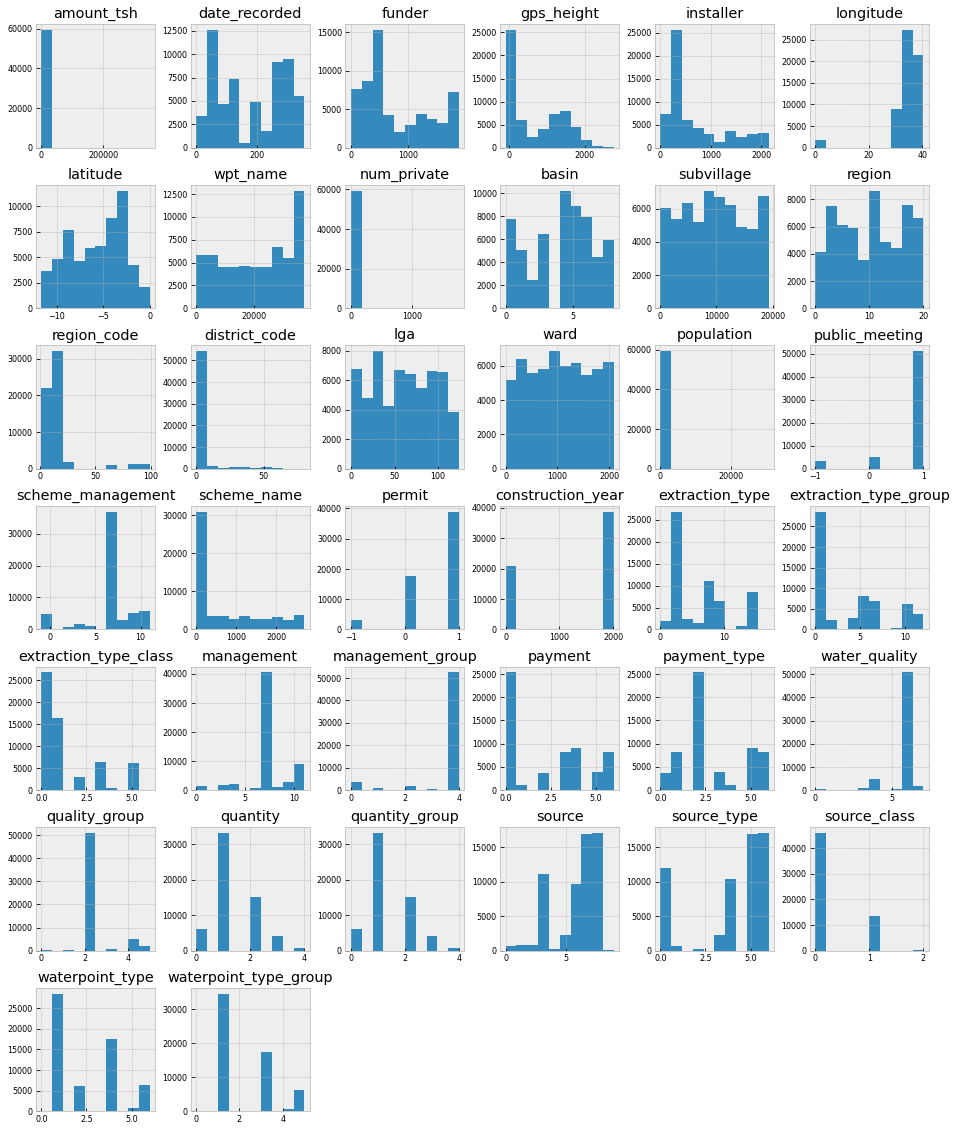

In [11]:
features_df.hist(figsize=(16, 20), xlabelsize=8, ylabelsize=8);

In [12]:
corr = features_df.corr()

<AxesSubplot:>

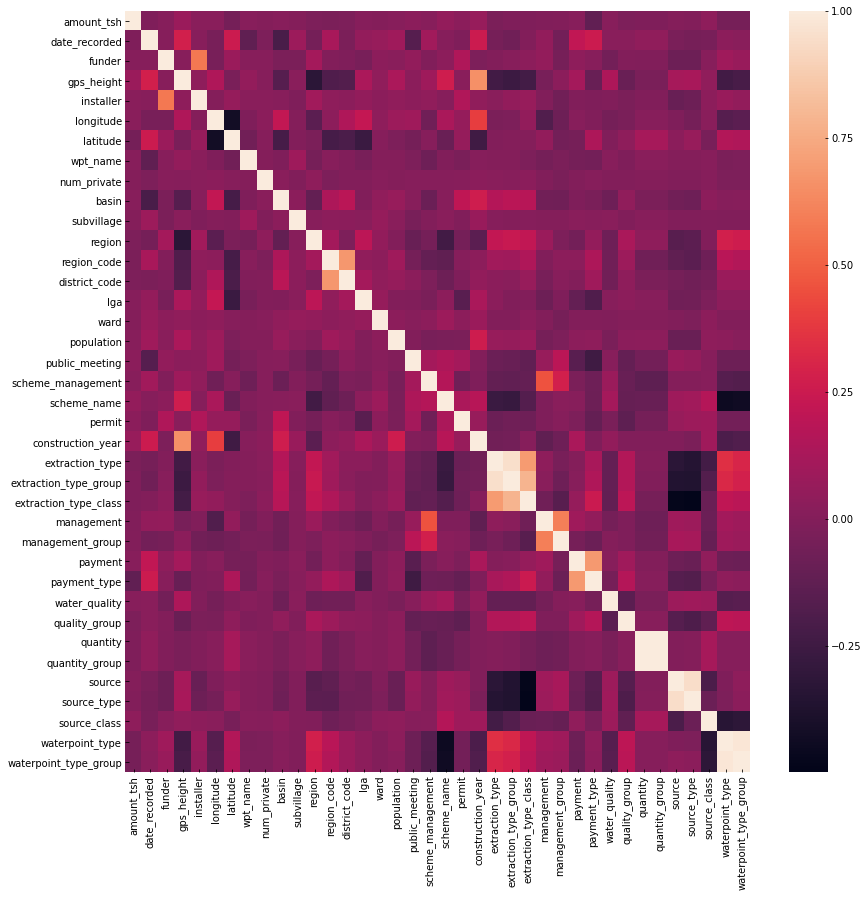

In [13]:
fig, ax = plt.subplots(figsize=(14,14)) 
sns.heatmap(corr)

# Modelling

In [14]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb


set_config(display='diagram')
RANDOM_SEED = 6    # Set a random seed for reproducibility!

In [15]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.33,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

In [16]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', MinMaxScaler()),
#     ('simple_imputer', SimpleImputer(strategy='mean')),
#     ('pca', PCA(n_components='mle'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder())
])

# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps,features_df.columns),
#         ('categorical', categorical_transformer, object_cols),
    ])

In [21]:
lr = LogisticRegression(penalty="l2", C=0.05)

# 0.86767
params = {
    "objective":"binary:logistic",
    'colsample_bytree':0.35,
    'learning_rate':0.19,
    'max_depth':7,
    'alpha':10,
    'min_child_weight':8,
    'n_estimators':105
    }

# params = {
#     'colsample_bytree':0.35,
#     'learning_rate':0.19,
#     'max_depth':8,
#     'alpha':5,
#     'min_child_weight':30,
#     'n_estimators':105,
#     }

svc = LinearSVC()
xgb_es = xgb.XGBClassifier()
rf = RandomForestClassifier(max_depth=1000,n_estimators=200)
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier",xgb_es),
])
full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', '...ame',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object'))])),
                ('classifier', XGBClassifier())])

In [22]:
%%time

# Train model
full_pipeline.fit(X_train, y_train)

# Predict on evaluation set
# This competition wants probabilities, not labels
preds = full_pipeline.predict(X_eval)

CPU times: user 17.5 s, sys: 30.5 ms, total: 17.5 s
Wall time: 17.5 s


In [23]:
accuracy_score(y_eval, preds)

0.7465564738292011

In [ ]:
from sklearn.utils.fixes import loguniform

param_grid = {
#     'classifier__n_estimators'        : [100,105,505,605]
    'classifier__max_depth'        : [5,10,15,20,25],
    'classifier__min_child_weight' :[5,10,15,20],
#     'classifier__gamma':[i/10.0 for i in range(0,5)],
#     'classifier__alpha':[5,8,10,12,14],
#     'classifier__colsample_bytree' : [i/100.0 for i in range(30,70,5)],
#     'classifier__subsample' : [0.3,0.5,1],
#     "classifier__learning_rate"    : [0.05, 0.10, 0.15, 0.19, 0.25, 0.30 ],
    }

grid_clf = GridSearchCV(full_pipeline, param_grid,cv=5,verbose=1)
grid_clf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
print(grid_clf.best_params_)
print(grid_clf.best_score_)
print(grid_clf.best_estimator_.score(X_eval, y_eval))

# Submission

In [ ]:
%%time 

full_pipeline.fit(features_df, labels_df)

None   # So we don't print out the whole pipeline representation

In [ ]:
test_probas = full_pipeline.predict(test_features_df)

In [ ]:
submission_df = pd.read_csv("SubmissionFormat.csv", 
                            index_col="id")

In [ ]:
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["status_group"] = test_probas

submission_df.head()

In [ ]:
submission_df.to_csv('my_submission.csv', index=True)